In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
# Check GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
# Load raw data
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(root="./data/",
                            train=True,
                            download=True,
                            transform=transform)

In [4]:
# Check image shape
print(dataset.data.shape)

torch.Size([60000, 28, 28])


In [5]:
# Define discriminator and generator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=784, out_features=1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        out = self.model(x)
        return out


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.BatchNorm1d(num_features=256, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(num_features=512, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(num_features=1024, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=28 * 28),
            nn.Tanh())

    def forward(self, x):
        out = self.model(x)
        out = out.view(-1, 1, 28, 28)
        return out

In [6]:
# Build discriminator and generator
discriminator = Discriminator()
generator = Generator()

discriminator.to(device)
generator.to(device)

print(f'Discriminator Structure:\n{discriminator}')
print(f'Generator Structure:\n{generator}')

Discriminator Structure:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Generator Structure:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_fea

In [7]:
# Function of plotting some images
def plot_some_images(tensor_set):
    plt.figure(figsize=(4, 4))
    for index, single in enumerate(tensor_set.data[:25]):
        fig = plt.subplot(5, 5, index + 1)
        fig.set_xticks([])
        fig.set_yticks([])
        single = single.cpu().detach().numpy().reshape(28, 28)
        plt.imshow(single, cmap='gray')
    plt.show()

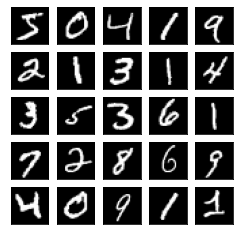

In [8]:
# Plot some real hand-written digit images
plot_some_images(dataset)

In [9]:
# Set batch size and put the dataset into dataloader
batch_size = 100
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Define optimizers of discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [11]:
# Fixed moise for evaluating the trained GAN model
fixed_noise = torch.randn(25, 100).to(device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, G_loss: 28.531837463378906, D_loss: 0.011611456982791424


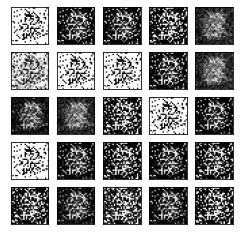

 22%|██▎       | 9/40 [01:53<06:26, 12.46s/it]

Epoch: 10/40, G_loss: 4.993382453918457, D_loss: 0.063715860247612


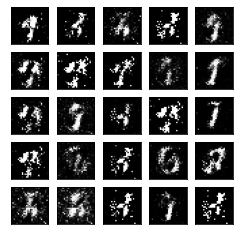

 48%|████▊     | 19/40 [03:57<04:17, 12.27s/it]

Epoch: 20/40, G_loss: 1.794488787651062, D_loss: 0.2822762727737427


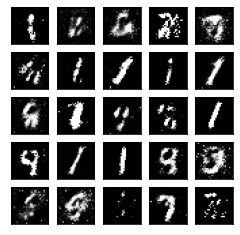

 72%|███████▎  | 29/40 [06:01<02:15, 12.28s/it]

Epoch: 30/40, G_loss: 2.2391433715820312, D_loss: 0.34409183263778687


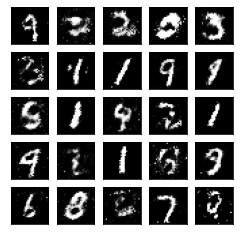

 98%|█████████▊| 39/40 [08:04<00:12, 12.27s/it]

Epoch: 40/40, G_loss: 1.8735462427139282, D_loss: 0.29210448265075684


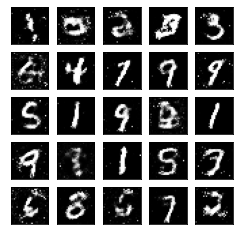

100%|██████████| 40/40 [08:18<00:00, 12.45s/it]


In [12]:
# Train a GAN model
n_epochs = 40

for epoch in tqdm(range(n_epochs)):
    for i, data in enumerate(data_loader):
        images = data[0].to(device)
        # Labels
        real = torch.ones(images.size(0), 1).to(device)
        fake = torch.zeros(images.size(0), 1).to(device)

        # Noise data for fake images
        noise = torch.randn(images.size(0), 100).to(device)
        images_fake = generator(noise)

        # Train generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(images_fake), real)
        g_loss.backward()
        g_optimizer.step()

        # Train discriminator
        d_optimizer.zero_grad()
        d_real_loss = criterion(discriminator(images), real)
        d_fake_loss = criterion(discriminator(images_fake.detach()), fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

    # Check GAN performance for every 10 epochs
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{n_epochs}, G_loss: {g_loss}, D_loss: {d_loss}')
        fixed_fake_images = generator(fixed_noise)
        plot_some_images(fixed_fake_images)